# Joining Tables

This is the fifth in a series of notebooks related to astronomy data.

As a continuing example, we will replicate part of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

Picking up where we left off, the next step in the analysis is to select candidate stars based on photometry data.
The following figure from the paper is a color-magnitude diagram for the stars selected based on proper motion:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

In red is a [stellar isochrone](https://en.wikipedia.org/wiki/Stellar_isochrone), showing where we expect the stars in GD-1 to fall based on the metallicity and age of their original globular cluster. 

By selecting stars in the shaded area, we can further distinguish the main sequence of GD-1 from younger background stars.

## Outline

Here are the steps in this notebook:

1. We'll reload the candidate stars we identified in the previous notebook.

2. Then we'll run a query on the Gaia server that uploads the table of candidates and uses a `JOIN` operation to select photometry data for the candidate stars.

3. We'll write the results to a file for use in the next notebook.

After completing this lesson, you should be able to

* Upload a table to the Gaia server.

* Write ADQL queries involving `JOIN` operations.

## Installing libraries

If you are running this notebook on Colab, you can run the following cell to install the libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  See the instructions in the preface.

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery

## Getting photometry data

The Gaia dataset contains some photometry data, including the variable `bp_rp`, which contains BP-RP color (the difference in mean flux between the BP and RP bands).
We use this variable to select stars with `bp_rp` between -0.75 and 2, which excludes many class M dwarf stars.

Now, to select stars with the age and metal richness we expect in GD-1, we will use `g-i` color and apparent `g`-band magnitude, which are available from the Pan-STARRS survey.

Conveniently, the Gaia server provides data from Pan-STARRS as a table in the same database we have been using, so we can access it by making ADQL queries.

In general, choosing a star from the Gaia catalog and finding the corresponding star in the Pan-STARRS catalog is not easy.  This kind of cross matching is not always possible, because a star might appear in one catalog and not the other.  And even when both stars are present, there might not be a clear one-to-one relationship between stars in the two catalogs.

Fortunately, smart people have worked on this problem, and the Gaia database includes cross-matching tables that suggest a best neighbor in the Pan-STARRS catalog for many stars in the Gaia catalog.

[This document describes the cross matching process](https://gea.esac.esa.int/archive/documentation/GDR2/Catalogue_consolidation/chap_cu9val_cu9val/ssec_cu9xma/sssec_cu9xma_extcat.html).  Briefly, it uses a cone search to find possible matches in approximately the right position, then uses attributes like color and magnitude to choose pairs of observations most likely to be the same star.

## The best neighbor table

So the hard part of cross-matching has been done for us.  Using the results is a little tricky, but it gives us a chance to learn about one of the most important tools for working with databases: "joining" tables.

In general, a "join" is an operation where you match up records from one table with records from another table using as a "key" a piece of information that is common to both tables, usually some kind of ID code.

In this example:

* Stars in the Gaia dataset are identified by `source_id`.

* Stars in the Pan-STARRS dataset are identified by `obj_id`.

For each candidate star we have selected so far, we have the `source_id`; the goal is to find the `obj_id` for the same star (we hope) in the Pan-STARRS catalog.

To do that we will:

1. Use the `JOIN` operator to look up each `source_id` in the `panstarrs1_best_neighbour` table, which contains the `obj_id` of the best match for each star in the Gaia catalog; then

2. Use the `JOIN` operator again to look up each `obj_id` in the `panstarrs1_original_valid` table, which contains the Pan-STARRS photometry data we want.

Before we get to the `JOIN` operation, let's explore these tables.
Here's the metadata for `panstarrs1_best_neighbour`.

In [103]:
meta = Gaia.load_table('gaiadr2.panstarrs1_best_neighbour')
print(meta)

Retrieving table 'gaiadr2.panstarrs1_best_neighbour'
Parsing table 'gaiadr2.panstarrs1_best_neighbour'...
Done.
TAP Table name: gaiadr2.gaiadr2.panstarrs1_best_neighbour
Description: Pan-STARRS1 BestNeighbour table lists each matched Gaia object with its
best neighbour in the external catalogue.
There are 1 327 157 objects in the filtered version of Pan-STARRS1 used
to compute this cross-match that have too early epochMean.
Num. columns: 7


And here are the columns.

In [104]:
for column in meta.columns:
    print(column.name)

source_id
original_ext_source_id
angular_distance
number_of_neighbours
number_of_mates
best_neighbour_multiplicity
gaia_astrometric_params


Here's the [documentation for these variables](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_crossmatches/ssec_dm_panstarrs1_best_neighbour.html) .

The ones we'll use are:

* `source_id`, which we will match up with `source_id` in the Gaia table.

* `number_of_neighbours`, which indicates how many sources in Pan-STARRS are matched with this source in Gaia.

* `number_of_mates`, which indicates the number of *other* sources in Gaia that are matched with the same source in Pan-STARRS.

* `original_ext_source_id`, which we will match up with `obj_id` in the Pan-STARRS table.

Ideally, `number_of_neighbours` should be 1 and `number_of_mates` should be 0; in that case, there is a one-to-one match between the source in Gaia and the corresponding source in Pan-STARRS.

Here's a query that selects these columns and returns the first 5 rows.

In [105]:
query = """SELECT 
TOP 5
source_id, number_of_neighbours, number_of_mates, original_ext_source_id
FROM gaiadr2.panstarrs1_best_neighbour
"""

In [106]:
from astroquery.gaia import Gaia

job = Gaia.launch_job_async(query=query)

INFO: Query finished. [astroquery.utils.tap.core]


In [107]:
results = job.get_results()
results

source_id,number_of_neighbours,number_of_mates,original_ext_source_id
int64,int32,int16,int64
6745938972433480704,1,0,69742925668851205
6030466788955954048,1,0,69742509325691172
6756488099308169600,1,0,69742879438541228
6700154994715046016,1,0,69743055581721207
6757061941303252736,1,0,69742856540241198


## The Pan-STARRS table

Here's the metadata for the table that contains the Pan-STARRS data.

In [85]:
meta = Gaia.load_table('gaiadr2.panstarrs1_original_valid')
print(meta)

Retrieving table 'gaiadr2.panstarrs1_original_valid'
Parsing table 'gaiadr2.panstarrs1_original_valid'...
Done.
TAP Table name: gaiadr2.gaiadr2.panstarrs1_original_valid
Description: The Panoramic Survey Telescope and Rapid Response System (Pan-STARRS) is
a system for wide-field astronomical imaging developed and operated by
the Institute for Astronomy at the University of Hawaii. Pan-STARRS1
(PS1) is the first part of Pan-STARRS to be completed and is the basis
for Data Release 1 (DR1). The PS1 survey used a 1.8 meter telescope and
its 1.4 Gigapixel camera to image the sky in five broadband filters (g,
r, i, z, y).

The current table contains a filtered subsample of the 10 723 304 629
entries listed in the original ObjectThin table.
We used only ObjectThin and MeanObject tables to extract
panstarrs1OriginalValid table, this means that objects detected only in
stack images are not included here. The main reason for us to avoid the
use of objects detected in stack images is that their a

And here are the columns.

In [86]:
for column in meta.columns:
    print(column.name)

obj_name
obj_id
ra
dec
ra_error
dec_error
epoch_mean
g_mean_psf_mag
g_mean_psf_mag_error
g_flags
r_mean_psf_mag
r_mean_psf_mag_error
r_flags
i_mean_psf_mag
i_mean_psf_mag_error
i_flags
z_mean_psf_mag
z_mean_psf_mag_error
z_flags
y_mean_psf_mag
y_mean_psf_mag_error
y_flags
n_detections
zone_id
obj_info_flag
quality_flag


Here's the [documentation for these variables]() .

The ones we'll use are:

* `obj_id`, which we will match up with `original_ext_source_id` in the best neighbor table.

* `g_mean_psf_mag`, which contains mean magnitude from the `i` filter.

* `i_mean_psf_mag`, which contains mean magnitude from the `i` filter.

Here's a query that selects these variables and returns the first 5 rows.

In [108]:
query = """SELECT 
TOP 5
obj_id, g_mean_psf_mag, i_mean_psf_mag 
FROM gaiadr2.panstarrs1_original_valid
"""

In [109]:
job = Gaia.launch_job_async(query=query)

INFO: Query finished. [astroquery.utils.tap.core]


In [110]:
results = job.get_results()
results

obj_id,g_mean_psf_mag,i_mean_psf_mag
,,mag
int64,float64,float64
67130655389101425,--,20.3516006469727
67553305590067819,--,19.779899597168
67551423248967849,--,19.8889007568359
67132026238911331,--,20.9062995910645
67553513677687787,--,21.2831001281738


The following figure shows how these tables are related.

* The orange circles and arrows represent the first `JOIN` operation, which takes each `source_id` in the Gaia table and finds the same value of `source_id` in the best neighbor table.

* The blue circles and arrows represent the second `JOIN` operation, which takes each `original_ext_source_id` in the Gaia table and finds the same value of `obj_id` in the best neighbor table.

There's no guarantee that the corresponding rows of these tables are in the same order, so the `JOIN` operation involves some searching.
However, ADQL/SQL databases are implemented in a way that makes this kind of source efficient.
If you are curious, you can [read more about it](https://chartio.com/learn/databases/how-does-indexing-work/).

<img src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/join.png">


## Joining tables

Now let's get to the details of performing a `JOIN` operation.
As a starting place, let's go all the way back to the cone search from Lesson 2.

In [91]:
query_cone = """SELECT 
TOP 10 
source_id
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
  POINT(ra, dec),
  CIRCLE(88.8, 7.4, 0.08333333))
"""

And let's run it, to make sure we have a working query to build on.

In [111]:
from astroquery.gaia import Gaia

job = Gaia.launch_job_async(query=query_cone)

INFO: Query finished. [astroquery.utils.tap.core]


In [112]:
results = job.get_results()
results

source_id,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907
3322773758899157120,88.83227057144585,7.325577341429926,--,--
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435


Now we can start adding features.
First, let's replace `source_id` with a format specifier, `columns`: 

In [114]:
query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
  POINT(ra, dec),
  CIRCLE(88.8, 7.4, 0.08333333))
"""

Here are the columns we want from the Gaia table, again. 

In [115]:
columns = 'source_id, ra, dec, pmra, pmdec'

query = query_base.format(columns=columns)
print(query)

SELECT 
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
  POINT(ra, dec),
  CIRCLE(88.8, 7.4, 0.08333333))



And let's run the query again.

In [116]:
job = Gaia.launch_job_async(query=query)

INFO: Query finished. [astroquery.utils.tap.core]


In [117]:
results = job.get_results()
results

source_id,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907
3322773758899157120,88.83227057144585,7.325577341429926,--,--
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008


## Adding the best neighbor table

Now we're ready for the first join.
The join operation requires two clauses:

* `JOIN` specifies the name of the table we want to join with, and

* `ON` specifies how we'll match up rows between the tables.

In this example, we join with `gaiadr2.panstarrs1_best_neighbour AS best`, which means we can refer to the best neighbor table with the abbreviated name `best`.

And the `ON` clause indicates that we'll match up the `source_id` column from the Gaia table with the `source_id` column from the best neighbor table. 

In [123]:
query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  ON gaia.source_id = best.source_id
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.08333333))
"""

**SQL detail:** In this example, the `ON` column has the same name in both tables, so we could replace the `ON` clause with a simpler [`USING` clause](https://docs.oracle.com/javadb/10.8.3.0/ref/rrefsqljusing.html):

```
USING(source_id)
```

Now that there's more than one table involved, we can't use simple column names any more; we have to use *qualified* column names.
In other words, we have to specify which table each column is in.
Here's the complete query, including the columns we want from the Gaia and best neighbor tables.

In [125]:
column_list = ['gaia.source_id',
               'gaia.ra',
               'gaia.dec',
               'gaia.pmra',
               'gaia.pmdec',
               'best.best_neighbour_multiplicity',
               'best.number_of_mates',
              ]
columns = ', '.join(column_list)

query = query_base.format(columns=columns)
print(query)

SELECT 
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  ON gaia.source_id = best.source_id
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.08333333))



In [126]:
job = Gaia.launch_job_async(query=query)

INFO: Query finished. [astroquery.utils.tap.core]


In [122]:
results = job.get_results()
results

source_id,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008
3322773724537890944,88.81241651540533,7.327864052479726,-0.36003627434304625,-6.393939291541333


Notice that this result has fewer rows than the previous result.
That's because there are sources in the Gaia table with no corresponding source in the Pan-STARRS table.

By default, the result of the join only includes rows where the same `source_id` appears in both tables.
This default is called an "inner" join because the results include only the intersection of the two tables.
[You can read about the other kinds of join here](https://www.geeksforgeeks.org/sql-join-set-1-inner-left-right-and-full-joins/).

### Exercise

Now we're ready to bring in the Pan-STARRS table.  Starting with the previous query, add a second `JOIN` clause that joins with `gaiadr2.panstarrs1_original_valid`, gives it the abbreviated name `ps`, and matches `original_ext_source_id` from the best neighbor table with `obj_id` from the Pan-STARRS table.

Add `g_mean_psf_mag` and `i_mean_psf_mag` to the column list, and run the query.
The result should contain 490 rows and 9 columns.

In [132]:
# Solution

query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source as gaia
JOIN gaiadr2.panstarrs1_best_neighbour as best
  ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid as ps
  ON best.original_ext_source_id = ps.obj_id
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.08333333))
"""


In [133]:
# Solution

column_list = ['gaia.source_id',
               'gaia.ra',
               'gaia.dec',
               'gaia.pmra',
               'gaia.pmdec',
               'best.best_neighbour_multiplicity',
               'best.number_of_mates',
               'ps.g_mean_psf_mag',
               'ps.i_mean_psf_mag',
              ]
columns = ', '.join(column_list)

query = query_base.format(columns=columns)
print(query)

SELECT 
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.gaia_source as gaia
JOIN gaiadr2.panstarrs1_best_neighbour as best
  ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid as ps
  ON best.original_ext_source_id = ps.obj_id
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.08333333))



In [134]:
# Solution

job = Gaia.launch_job_async(query=query)

INFO: Query finished. [astroquery.utils.tap.core]


In [135]:
# Solution

results = job.get_results()
results

source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
,deg,deg,mas / yr,mas / yr,,,,mag
int64,float64,float64,float64,float64,int16,int16,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907,1,0,19.9431991577148,17.4221992492676
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044,1,0,18.6212005615234,16.6007995605469
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717,1,0,--,20.2203998565674
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435,1,0,18.0676002502441,16.9762001037598
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086,1,0,20.1907005310059,17.8700008392334
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576,1,0,22.6308002471924,19.6004009246826
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008,1,0,21.2119998931885,18.3528003692627
3322773724537890944,88.81241651540533,7.327864052479726,-0.36003627434304625,-6.393939291541333,1,0,20.8094005584717,18.1343002319336


## Selecting by coordinates and proper motion

Now let's bring in the `WHERE` clause from the previous notebook, which selects sources based on `parallax`, `bp_rp`, sky coordinates, and proper motion.
Rather than rewrite the code we use to generate the query, we can start with a copy of the complete query:

In [136]:
query6 = """
SELECT 
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND 1 = CONTAINS(POINT(pmra, pmdec),
                   POLYGON( -4.05037121,-14.75623261, -3.41981085,-14.72365546, -3.03521988,-14.44357135, -2.26847919,-13.7140236 , -2.61172203,-13.24797471, -2.73471401,-13.09054471, -3.19923146,-12.5942653 , -3.34082546,-12.47611926, -5.67489413,-11.16083338, -5.95159272,-11.10547884, -6.42394023,-11.05981295, -7.09631023,-11.95187806, -7.30641519,-12.24559977, -7.04016696,-12.88580702, -6.00347705,-13.75912098, -4.42442296,-14.74641176))
"""

Again, let's run it to make sure we are starting with a working query.

In [137]:
job = Gaia.launch_job_async(query=query6)

INFO: Query finished. [astroquery.utils.tap.core]


In [139]:
results = job.get_results()
results

source_id,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
635559124339440000,137.58671691646745,19.1965441084838,-3.770521900009566,-12.490481778113859
635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392
635674126383965568,138.8428741026386,19.031798198627634,-3.8970011609340207,-12.702779525389634
635535454774983040,137.8377518255436,18.864006786112604,-4.335040664412791,-14.492308604905652
635497276810313600,138.0445160213759,19.00947118796605,-7.1729306406216615,-12.291499169815987
635614168640132864,139.59219748145836,18.807955539071433,-3.309602916796381,-13.708904908478631
635821843194387840,139.88094034815086,19.62185456718988,-6.544201177153814,-12.55978220563274
635551706931167104,138.04665586038192,19.248909662830798,-6.224595114220405,-12.224246333795001


### Exercise

Create a new query base called `query7_base` that combines the `WHERE` clauses from the previous query with the `JOIN` clauses for the best neighbor and Pan-STARRS tables.
Format the query base using the `columns` from the previous query, and call the result `query7`.

Hint: Make sure you use qualified column names everywhere!

Run your query and download the results.  The table you get should have 3725 rows and 9 columns.

In [140]:
# Solution

query7_base = """
SELECT 
{columns}
FROM gaiadr2.gaia_source as gaia
JOIN gaiadr2.panstarrs1_best_neighbour as best
  ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid as ps
  ON best.original_ext_source_id = ps.obj_id
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(gaia.ra, gaia.dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND 1 = CONTAINS(POINT(gaia.pmra, gaia.pmdec),
                   POLYGON( -4.05037121,-14.75623261, -3.41981085,-14.72365546, -3.03521988,-14.44357135, -2.26847919,-13.7140236 , -2.61172203,-13.24797471, -2.73471401,-13.09054471, -3.19923146,-12.5942653 , -3.34082546,-12.47611926, -5.67489413,-11.16083338, -5.95159272,-11.10547884, -6.42394023,-11.05981295, -7.09631023,-11.95187806, -7.30641519,-12.24559977, -7.04016696,-12.88580702, -6.00347705,-13.75912098, -4.42442296,-14.74641176))
"""

In [141]:
# Solution

query7 = query7_base.format(columns=columns)
print(query7)


SELECT 
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.gaia_source as gaia
JOIN gaiadr2.panstarrs1_best_neighbour as best
  ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid as ps
  ON best.original_ext_source_id = ps.obj_id
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(gaia.ra, gaia.dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND 1 = CONTAINS(POINT(gaia.pmra, gaia.pmdec),
                   POLYGON( -4.05037121,-14.75623261, -3.41981085,-14.72365546, -3.03521988,-14.44357135, -2.26847919,-13.7140236 , -2.61172203,-13.24797471, -2.73471401,-13.09054471, -3.19923146,-12.5942653 , -3.34082546,-12.47611926, -5.67489413,-11.16083338, -5.95159272,-11.10547884, -6.42394023,-11.05981295, -7.09631023,-11.95187806, -7.30641519,-12.24559977, -7.

In [142]:
# Solution

job = Gaia.launch_job_async(query=query7)

INFO: Query finished. [astroquery.utils.tap.core]


In [143]:
# Solution

results = job.get_results()
results

source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
,deg,deg,mas / yr,mas / yr,,,,mag
int64,float64,float64,float64,float64,int16,int16,float64,float64
635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392,1,0,17.8978004455566,17.5174007415771
635674126383965568,138.8428741026386,19.031798198627634,-3.8970011609340207,-12.702779525389634,1,0,19.2873001098633,17.6781005859375
635535454774983040,137.8377518255436,18.864006786112604,-4.335040664412791,-14.492308604905652,1,0,16.9237995147705,16.478099822998
635497276810313600,138.0445160213759,19.00947118796605,-7.1729306406216615,-12.291499169815987,1,0,19.9242000579834,18.3339996337891
635614168640132864,139.59219748145836,18.807955539071433,-3.309602916796381,-13.708904908478631,1,0,16.1515998840332,14.6662998199463
635598607974369792,139.20920023089508,18.624132868942702,-6.124445176881091,-12.833824027100611,1,0,16.5223999023438,16.1375007629395
635737661835496576,139.93327552473934,19.167962454651423,-7.119403303682826,-12.687947497633793,1,0,14.5032997131348,13.9849004745483
635850945892748672,139.86542888472115,20.011312663154804,-3.786655365804428,-14.28415600718206,1,0,16.5174999237061,16.0450000762939


## Checking the match

To get more information about the matching process, we can inspect `best_neighbour_multiplicity`, which indicates for each star in Gaia how many stars in Pan-STARRS are equally likely matches.

In [144]:
results['best_neighbour_multiplicity']

1
1
1
1
1
1
1
1
1
1
1


It looks like most of the values are `1`, which is good; that means that for each candidate star we have identified exactly one source in Pan-STARRS that is likely to be the same star.

To check whether there are any values other than `1`, we can convert this column to a Pandas `Series` and use `describe`, which we saw in in Lesson 3.

In [50]:
import pandas as pd

multiplicity = pd.Series(results['best_neighbour_multiplicity'])
multiplicity.describe()

count    3725.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

In fact, `1` is the only value in the `Series`, so every candidate star has a single best match.

Similarly, `number_of_mates` indicates the number of *other* stars in Gaia that match with the same star in Pan-STARRS.

In [51]:
mates = pd.Series(results['number_of_mates'])
mates.describe()

count    3725.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

All values in this column are `0`, which means that for each match we found in Pan-STARRS, there are no other stars in Gaia that also match. 

**Detail:** The table also contains `number_of_neighbors` which is the number of stars in Pan-STARRS that match in terms of position, before using other criteria to choose the most likely match.  But we are more interested in the final match, using both criteria.

## Transforming coordinates



In [57]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from gala.coordinates import GD1Koposov10
from gala.coordinates import reflex_correct

def make_dataframe(table):
    """Transform coordinates from ICRS to GD-1 frame.
    
    table: Astropy Table
    
    returns: Pandas DataFrame
    """
    skycoord = SkyCoord(
               ra=table['ra'], 
               dec=table['dec'],
               pm_ra_cosdec=table['pmra'],
               pm_dec=table['pmdec'], 
               distance=8*u.kpc, 
               radial_velocity=0*u.km/u.s)

    gd1_frame = GD1Koposov10()
    transformed = skycoord.transform_to(gd1_frame)
    skycoord_gd1 = reflex_correct(transformed)

    df = table.to_pandas()
    df['phi1'] = skycoord_gd1.phi1
    df['phi2'] = skycoord_gd1.phi2
    df['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
    df['pm_phi2'] = skycoord_gd1.pm_phi2
    return df

In [58]:
candidate_df = make_dataframe(results)

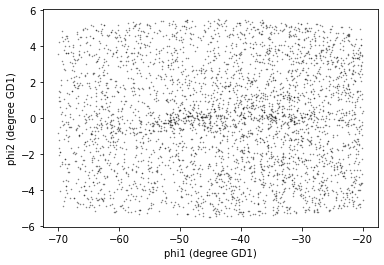

In [59]:
x = candidate_df['phi1']
y = candidate_df['phi2']
plt.plot(x, y, 'ko', markersize=0.5, alpha=0.5)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)');

## Saving the DataFrame

Let's save this `DataFrame` so we can pick up where we left off without running this query again.

The HDF file should already exist, so we'll add `candidate_df` to it.

In [49]:
filename = 'gd1_data.hdf'

candidate_df.to_hdf(filename, 'candidate_df')

We can use `getsize` to confirm that the file exists and check the size:

In [50]:
from os.path import getsize

MB = 1024 * 1024
getsize(filename) / MB

2.575897216796875

## CSV

Pandas can write a variety of other formats, [which you can read about here](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

We won't cover all of them, but one other important one is [CSV](https://en.wikipedia.org/wiki/Comma-separated_values), which stands for "comma-separated values".

CSV is a plain-text format that can be read and written by pretty much any tool that works with data.  In that sense, it is the "least common denominator" of data formats.

However, it has an important limitation: some information about the data gets lost in translation, notably the data types.  If you read a CSV file from someone else, you might need some additional information to make sure you are getting it right.

Also, CSV files tend to be big, and slow to read and write.

With those caveats, here's how to write one:

In [51]:
candidate_df.to_csv('gd1_data.csv')

We can check the file size like this:

In [52]:
getsize('gd1_data.csv') / MB

1.238297462463379

We can see the first few lines like this:

In [60]:
def head(filename, n=3):
    """Print the first `n` lines of a file."""
    with open(filename) as fp:
        for i in range(n):
            print(next(fp))

In [56]:
head('gd1_data.csv')

,source_id,ra,dec,pmra,pmdec,phi1,phi2,pm_phi1,pm_phi2

0,635559124339440000,137.58671691646745,19.1965441084838,-3.770521900009566,-12.490481778113859,-59.63048941944402,-1.2164852515042963,-7.361362712597496,-0.592632882064492

1,635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392,-59.247329893833296,-2.016078400820631,-7.527126084640531,1.7487794924176672



The CSV file contains the names of the columns, but not the data types.

We can read the CSV file back like this:

In [57]:
read_back_csv = pd.read_csv('gd1_data.csv')

Let's compare the first few rows of `candidate_df` and `read_back_csv`

In [58]:
candidate_df.head(3)

,source_id,ra,dec,pmra,pmdec,phi1,phi2,pm_phi1,pm_phi2
0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,-59.630489,-1.216485,-7.361363,-0.592633
1,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,-59.247330,-2.016078,-7.527126,1.748779
2,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,-59.133391,-2.306901,-7.560608,-0.741800


In [59]:
read_back_csv.head(3)

,Unnamed: 0,source_id,ra,dec,pmra,pmdec,phi1,phi2,pm_phi1,pm_phi2
0,0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,-59.630489,-1.216485,-7.361363,-0.592633
1,1,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,-59.247330,-2.016078,-7.527126,1.748779
2,2,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,-59.133391,-2.306901,-7.560608,-0.741800


Notice that the index in `candidate_df` has become an unnamed column in `read_back_csv`.  The Pandas functions for writing and reading CSV files provide options to avoid that problem, but this is an example of the kind of thing that can go wrong with CSV files.

## Summary

In this notebook, we used database `JOIN` operations to select photometry data for the stars we've identified as candidates to be in GD-1.

In the next notebook, we'll use this data for a second round of selection, identifying stars that have photometry data consistent with GD-1.

## Best practice

* Use `JOIN` operations to combine data from multiple tables in a databased, using some kind of identifier to match up records from one table with records from another.

* This is another example of a practice we saw in the previous notebook, moving the computation to the data.

* For most applications, saving data in FITS or HDF5 is better than CSV.  FITS and HDF5 are binary formats, so the files are usually smaller, and they store metadata, so you don't lose anything when you read the file back.

* On the other hand, CSV is a "least common denominator" format; that is, it can be read by practically any application that works with data.